In [10]:
color_mapping = {
    'F': (0.0, 0.0, 1.0, 0.6),    # darkblue with 0.6 alpha
    'C': (0.5, 0.5, 0.5, 0.6),     # grey with 0.6 alpha
    'B': (0.5451, 0.0, 0.0, 0.6)}  # darkred with 0.6 alpha

color_mapping_seasons = {
    'Summer': (1.0, 0.6471, 0.0, 0.6), # orange with 0.6 alpha
    'Winter': (0.0, 0.0, 1.0, 0.6)}     # blue with 0.6 alpha}

quintile_mapping = {1: 'F', 2: 'C', 3: 'B'}
quintile_cats = ['F', 'C', 'B']
n= 3
quintile_cats_season = ['Summer', 'Winter']    

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import os
import sys
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt    
import re
import pickle
import matplotlib.patches as mpatches
from statsmodels.graphics.mosaicplot import mosaic
from tabulate import tabulate

sys.path.insert(1, '../')
# from Create_Profiles_Functions import *
from Prepare_Data_Functions import *
from Plot_events_functions import *

def is_multiple_of_3(lst):
    return len(lst) % 3 == 0

In [12]:
    filepath="UKCP18_30mins/bc005/good"
    with open(f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/{filepath}_trimmed_events.pkl", 'rb') as f:
        trimmed_events = pickle.load(f)    
    trimmed_events

[    Unnamed: 0  precipitation (mm/hr)                times  \
 0         9760               4.508156  2001-07-24 08:15:00   
 1         9761               1.768947  2001-07-24 08:45:00   
 2         9762               0.000378  2001-07-24 09:15:00   
 3         9763               0.122280  2001-07-24 09:45:00   
 4         9764               2.356540  2001-07-24 10:15:00   
 5         9765               0.455514  2001-07-24 10:45:00   
 6         9766               0.001381  2001-07-24 11:15:00   
 7         9767               0.000003  2001-07-24 11:45:00   
 8         9768               0.000004  2001-07-24 12:15:00   
 9         9769               0.000028  2001-07-24 12:45:00   
 10        9770               0.527107  2001-07-24 13:15:00   
 11        9771              14.863884  2001-07-24 13:45:00   
 12        9772               1.952158  2001-07-24 14:15:00   
 
     precipitation (mm)  is_dry  Rolling_Sum  consecutive_dry  \
 0             2.254078   False     2.254078       

In [41]:
df= trimmed_events[0]
get_season(extract_first_date(df))

'2001-07-24 08:15:00'

# Create mosaic plots from UKCP18 data
For events with n data points which is a multiple of 5

In [13]:
ukcp18_present = read_and_format_events("UKCP18_30mins/bc005/good", n, quintile_mapping, quintile_cats)
# ukcp18_present_divisibley5 = ukcp18_present[ukcp18_present['duration']==2.5]
ukcp18_present_divisibleby3 = ukcp18_present[ukcp18_present['precipitation (mm/hr)'].apply(is_multiple_of_3)]

TypeError: read_and_format_events() takes 1 positional argument but 4 were given

In [ ]:
ukcp18_future = read_and_format_events("UKCP18_30mins/bb198/good",n, quintile_mapping, quintile_cats)
# ukcp18_present_divisibley5 = ukcp18_present[ukcp18_present['duration']==2.5]
ukcp18_future_divisibleby3 = ukcp18_future[ukcp18_future['precipitation (mm/hr)'].apply(is_multiple_of_3)]

In [ ]:
nimrod = read_and_format_events("NIMROD_30mins/WholeYear/NIMROD_2.2km_filtered_100_good",n, quintile_mapping, quintile_cats)
# nimrod_divisibley5  = nimrod[nimrod['duration']==2.5]
nimrod_divisibley3 = nimrod[nimrod['precipitation (mm/hr)'].apply(is_multiple_of_3)]

In [32]:
def calculate_center_of_mass(rainfall_event):
    total_rainfall = np.sum(rainfall_event)
    time_steps = np.arange(len(rainfall_event))
    center_of_mass = np.sum(time_steps * rainfall_event) / total_rainfall
    return center_of_mass

def categorize_rainfall_events_center_of_mass(rainfall_events):
    categories = {'front': 0, 'middle': 0, 'back': 0}
    total_events = len(rainfall_events)
    
    for event in rainfall_events:
        center_of_mass = calculate_center_of_mass(event)
        # Normalize the center of mass to a scale of 0 to 1
        normalized_com = center_of_mass / len(event)
        
        # Determine the loading category based on the center of mass
        if normalized_com < 1/3:
            categories['front'] += 1
        elif 1/3 <= normalized_com <= 2/3:
            categories['middle'] += 1
        else:
            categories['back'] += 1
    
    # Calculate proportions
    for key in categories:
        categories[key] = round(categories[key] /total_events,2)
#         categories[key] /= total_events
    
    return categories

# Example usage with synthetic data
rainfall_events = [
    [1, 2, 1, 3, 5, 2, 1, 1],  # Example event
    [2, 1, 1, 4, 6, 2, 2, 1],  # Another example event
    [1, 1, 5, 6, 2, 1, 1, 1],  # Another example event
    # Add more events here
]

proportions = categorize_rainfall_events_center_of_mass(nimrod['precipitation (mm/hr)'])
print(proportions)
proportions = categorize_rainfall_events_center_of_mass(ukcp18_present['precipitation (mm/hr)'])
print(proportions)
proportions = categorize_rainfall_events_center_of_mass(ukcp18_future['precipitation (mm/hr)'])
print(proportions)


{'front': 0.19, 'middle': 0.71, 'back': 0.1}
{'front': 0.21, 'middle': 0.69, 'back': 0.1}
{'front': 0.21, 'middle': 0.7, 'back': 0.09}


## Check overall distribution between categories

In [ ]:
# Desired order of loading categories
fig, axs = plt.subplots(nrows =3, figsize=(16,4), sharex=True)
create_single_variable_mosaic_plot(axs[0], nimrod_divisibley3, 'Loading', quintile_cats,color_mapping, 'NIMROD')
create_single_variable_mosaic_plot(axs[1], ukcp18_present_divisibleby3, 'Loading', quintile_cats, color_mapping, 'UKCP18_present')
create_single_variable_mosaic_plot(axs[2], ukcp18_future_divisibleby3, 'Loading', quintile_cats,color_mapping, 'UKCP18_future')

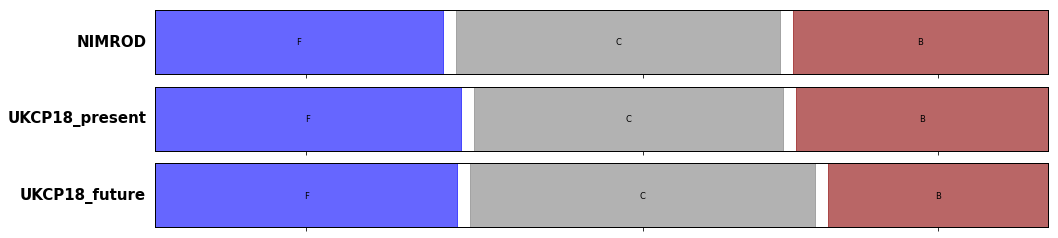

In [13]:
# Desired order of loading categories
fig, axs = plt.subplots(nrows =3, figsize=(16,4), sharex=True)
create_single_variable_mosaic_plot(axs[0], nimrod, 'Loading', quintile_cats,color_mapping, 'NIMROD')
create_single_variable_mosaic_plot(axs[1], ukcp18_present, 'Loading', quintile_cats, color_mapping, 'UKCP18_present')
create_single_variable_mosaic_plot(axs[2], ukcp18_future, 'Loading', quintile_cats,color_mapping, 'UKCP18_future')

## Compare proportion of events in each loading category (split by duration)

In [ ]:
fig, axs = plt.subplots(ncols =2, figsize=(16,8))
create_mosaic_plot(axs[0],nimrod_events_5 , cross_variable1 = 'DurationRange_personalised', cross_variable2='Loading', include_all= False)
axs[0].set_title('NIMROD', fontsize=20)
create_mosaic_plot(axs[1],ukcp18_events_5, cross_variable1 = 'DurationRange_personalised', cross_variable2='Loading', include_all= False)
axs[1].set_title('UKCP18', fontsize=20);

# Mosaic plots - split by season

In [ ]:
fig, axs = plt.subplots(ncols =2, figsize=(16,8))
create_mosaic_plot(axs[0],nimrod_events_5 , cross_variable1 = 'DurationRange_personalised', cross_variable2='Season', include_all= False)
axs[0].set_title('NIMROD', fontsize=20)
create_mosaic_plot(axs[1],ukcp18_events_5, cross_variable1 = 'DurationRange_personalised', cross_variable2='Season', include_all= False)
axs[1].set_title('UKCP18', fontsize=20);